In [1]:
using AlfvenDetectors
using PyPlot
using BSON
using Flux
using ValueHistories
using StatsBase
using Random

In [2]:
using PyCall
umap = pyimport("umap")

PyObject <module 'umap' from '/home/vit/anaconda3/lib/python3.7/site-packages/umap/__init__.py'>

In [3]:
# include the eval utilities code
adpath = dirname(dirname(pathof(AlfvenDetectors)))
include(joinpath(adpath, "experiments/eval_utils.jl"))

labeled_data

In [4]:
modelpath = "/home/vit/vyzkum/alfven/experiments/conv/uprobe/"

"/home/vit/vyzkum/alfven/experiments/conv/uprobe/"

In [6]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/uprobe_data/"
labeled_shots, shot_labels = labeled_data()
Random.seed!(123)
iused = sample(1:size(labeled_shots,1), 10, replace=false)
labeled_shots = labeled_shots[iused]
shot_labels = shot_labels[iused]
datafiles = readdir(datapath);
println("$(length(datafiles)) shots available")

1028 shots available


In [7]:
patchsize = 128
readfun = AlfvenDetectors.readnormlogupsd
data_labels = []
data_shotnos = []
data = Array{Float32,4}(undef,patchsize,patchsize,1,0)
for (label, shot) in zip(shot_labels, labeled_shots)
    file = joinpath.(datapath, datafiles[map(x->occursin("$shot", x),datafiles)])
    X = AlfvenDetectors.collect_conv_signals(file, readfun, patchsize)
    N = size(X,4)
    data = cat(data,X,dims=4)
    push!(data_labels, fill(label,N))
    push!(data_shotnos, fill(shot,N))
end
data_labels = vcat(data_labels...);
data_shotnos = vcat(data_shotnos...);

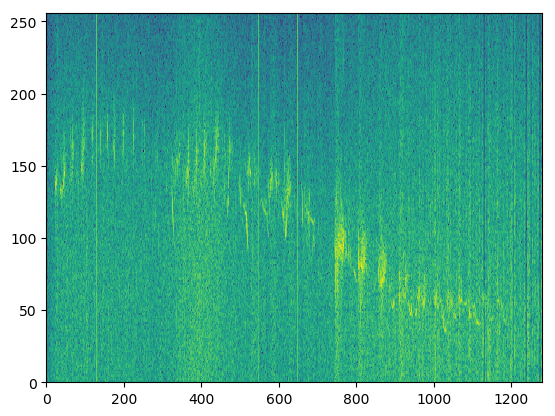

(128, 128, 1, 20)

In [8]:
testdata = readfun(joinpath(datapath, "uprobe_10893.h5"));
testdata = testdata[129:384, 1537:2816]
figure()
pcolormesh(testdata)
testdata = AlfvenDetectors.split_reshape(testdata,patchsize);
size(testdata)

In [58]:
mf = joinpath(modelpath, "batchnorm-test/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-05T17:03:35.079.bson")
# this is the best model, however it was trained on the 10893 data
#mf = joinpath(modelpath, "benchmark-runs/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_outbatchnorm-false_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-11T22:20:35.763.bson")
#mf = joinpath(modelpath, "benchmark-runs/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_outbatchnorm-true_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-11T20:12:06.821.bson")
model_data = BSON.load(mf)
params = parse_params(mf)
hist = model_data[:history]
model = model_data[:model]
if get(params, :batchnorm, false)
    Flux.testmode!(model);
end
display(params)
is,ls = get(hist,:loss)
vl = AlfvenDetectors.loss(model, testdata).data
println("trainig loss: $(ls[end])")
println("validation loss: $vl")

Dict{Any,Any} with 15 entries:
  :channels        => [2, 4]
  :ldim            => 64
  :time            => "2019-04-05T17:03:35.079"
  :eta             => 0.001
  :nlayers         => 2
  :nepochs         => 1000
  :xdim            => (128, 128, 1)
  :kernelsize      => 3
  :scaling         => 2
  :batchnorm       => true
  :batchsize       => 128
  :opt             => RMSProp
  :usegpu          => true
  :memoryefficient => true
  :model           => "ConvAE"

trainig loss: 0.0036269312
validation loss: 0.003676641


Check the reconstructions.

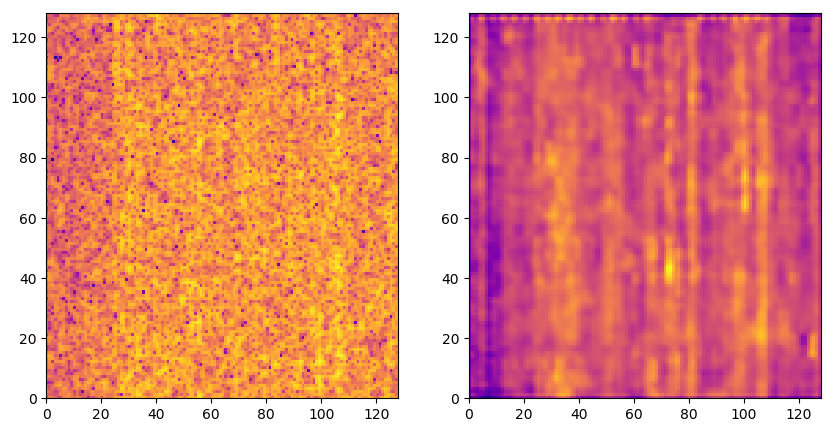

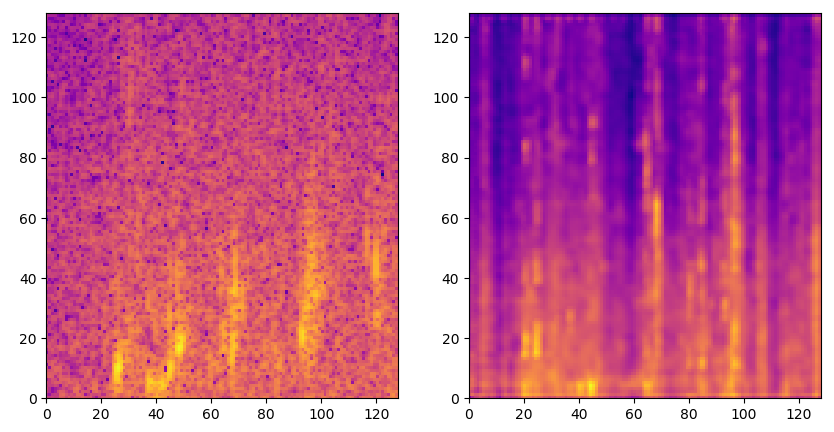

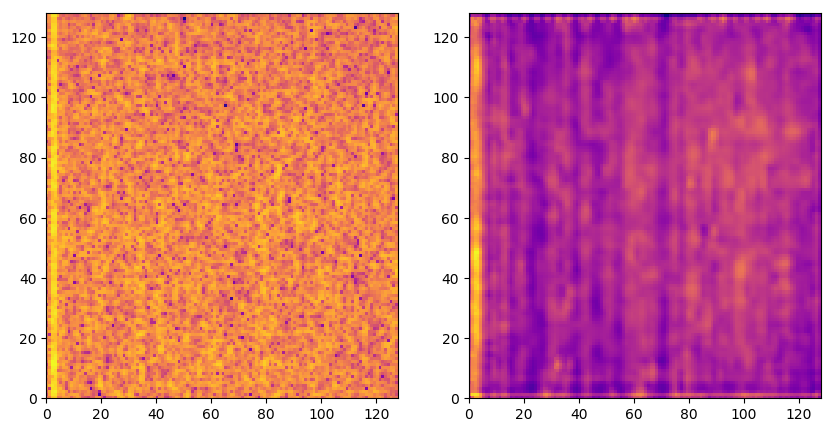

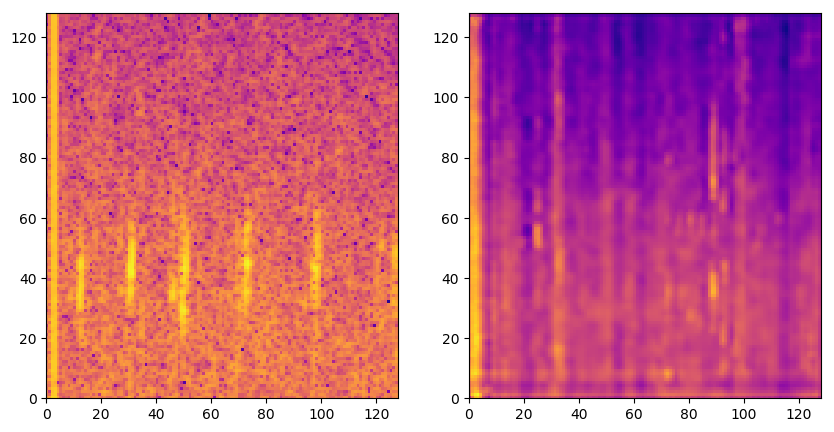

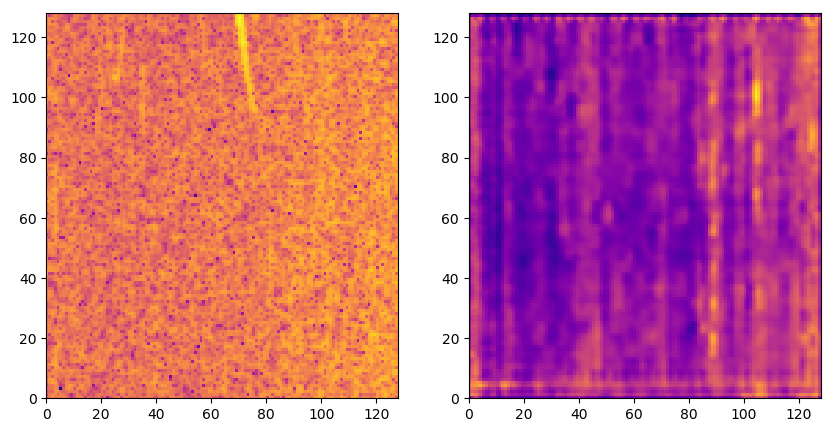

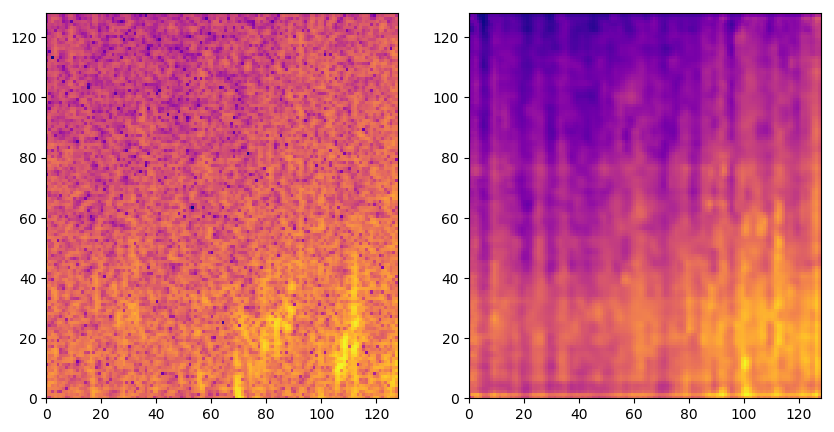

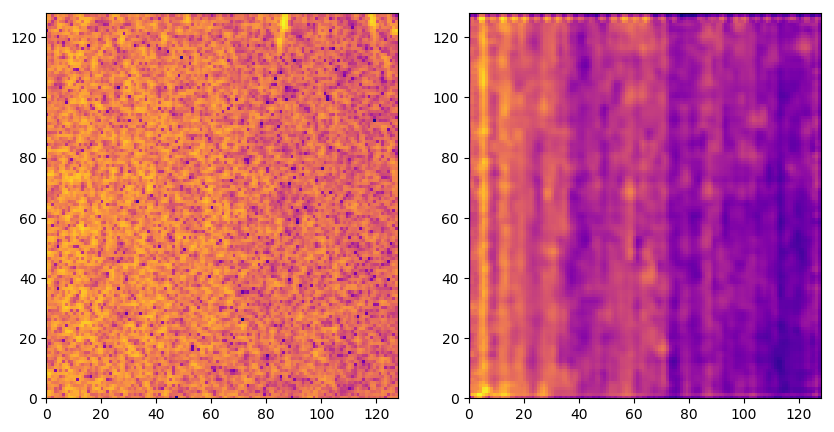

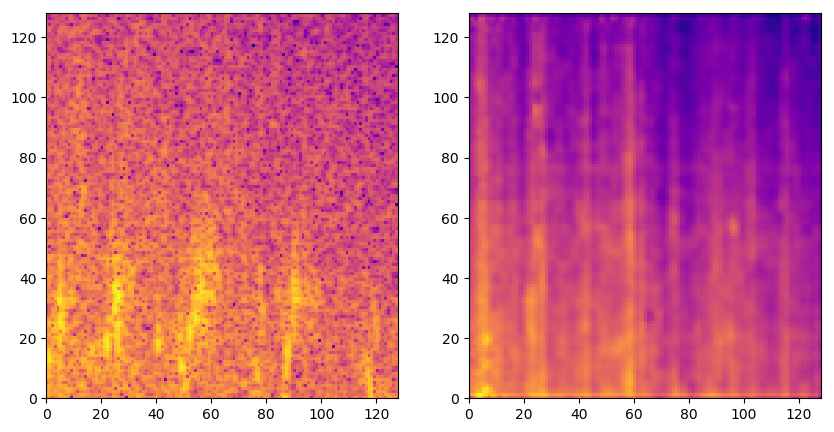

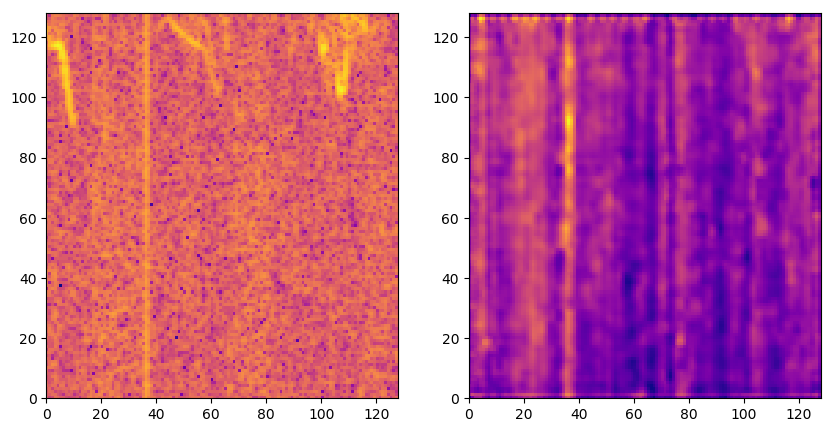

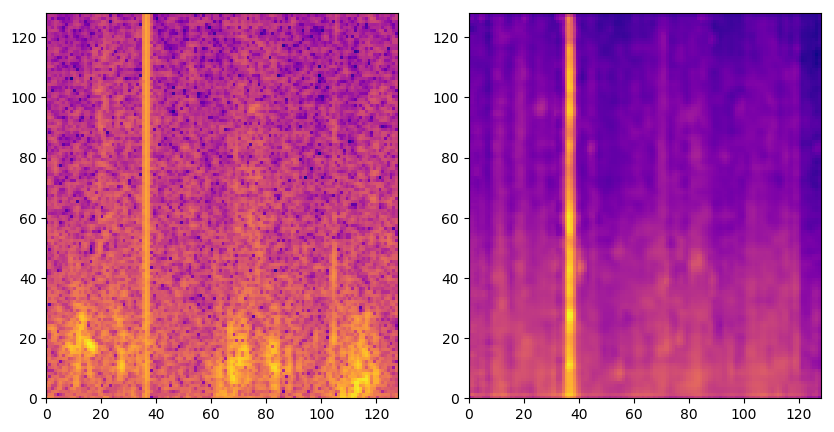

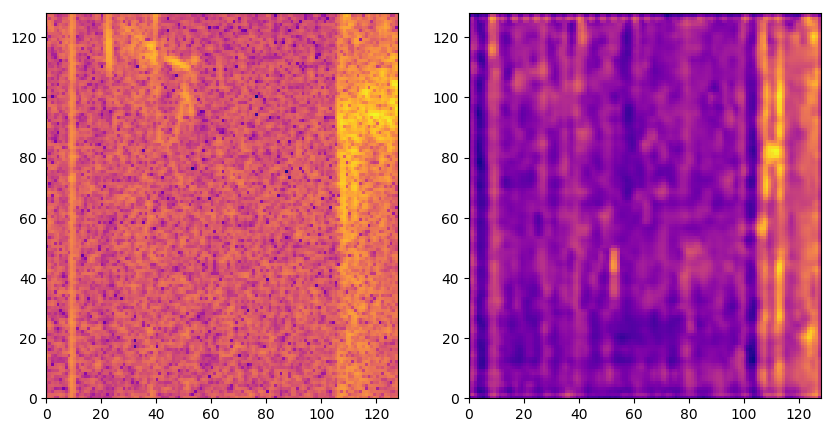

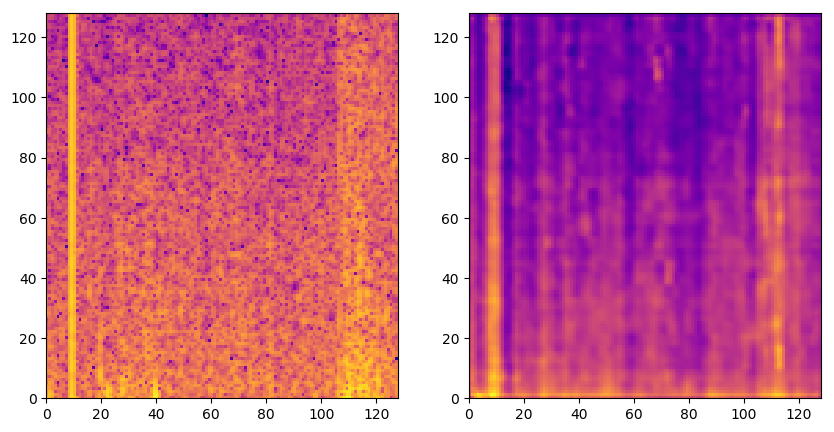

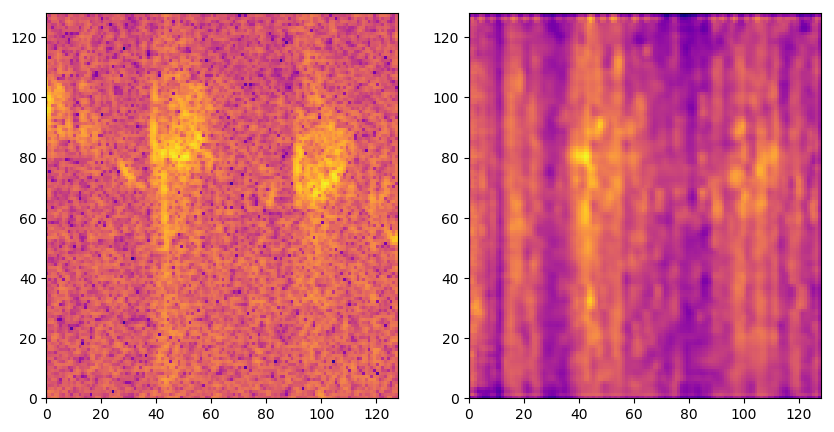

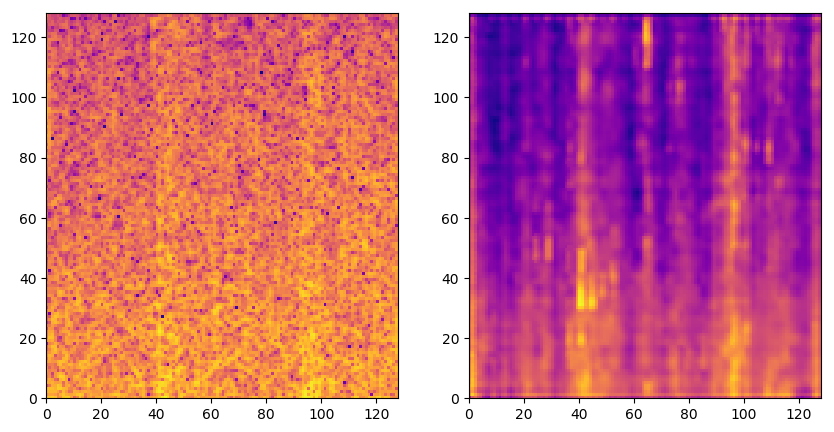

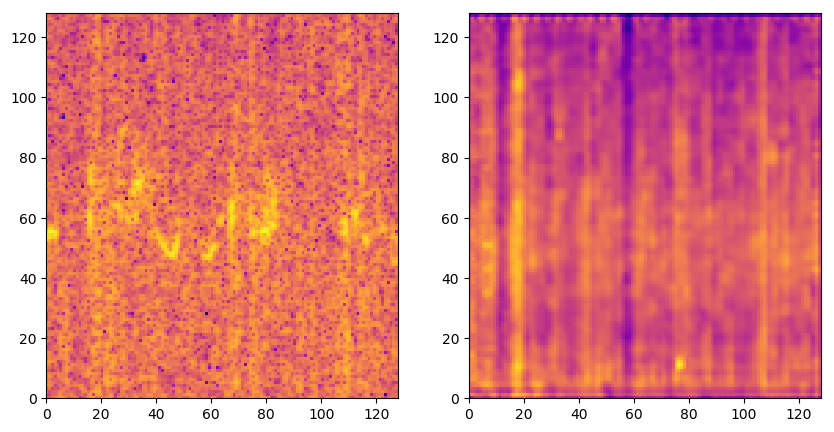

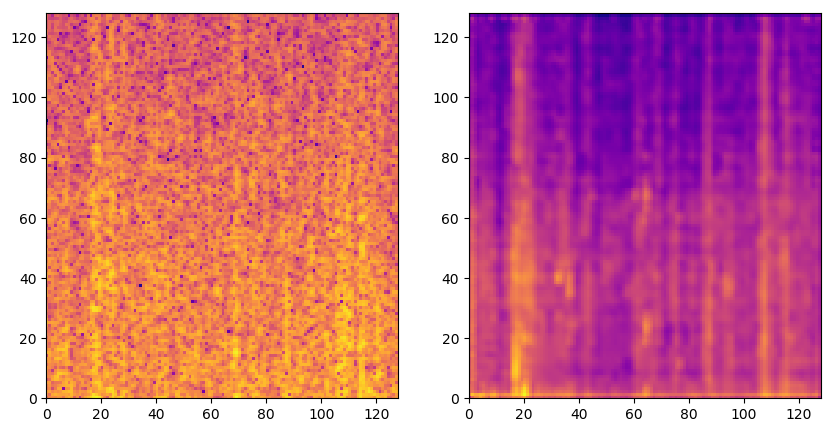

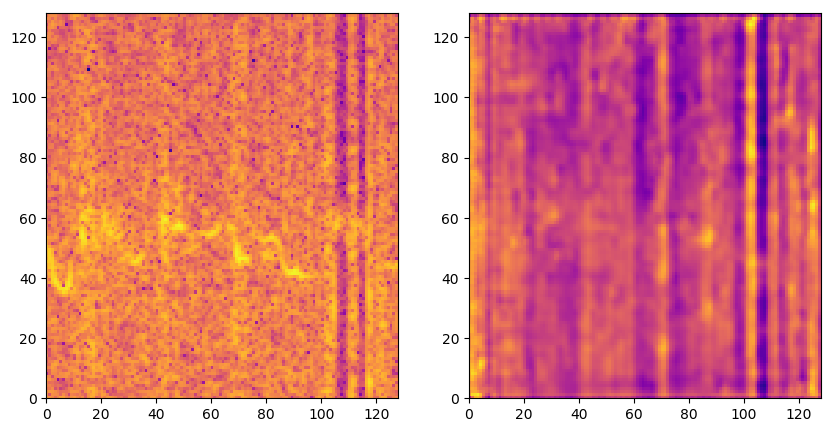

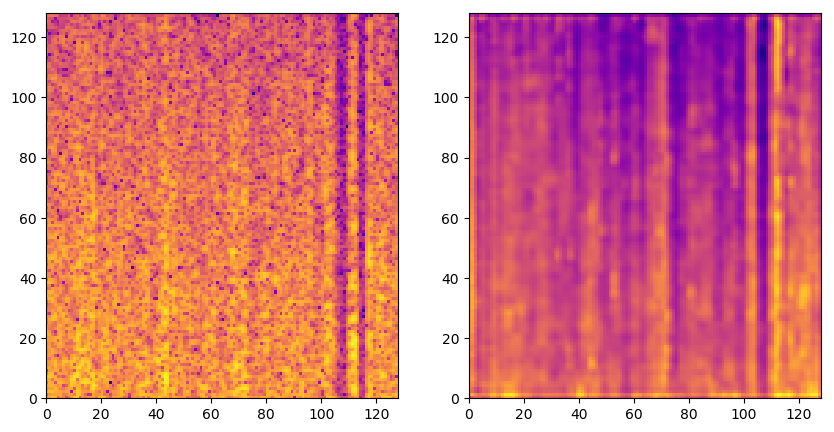

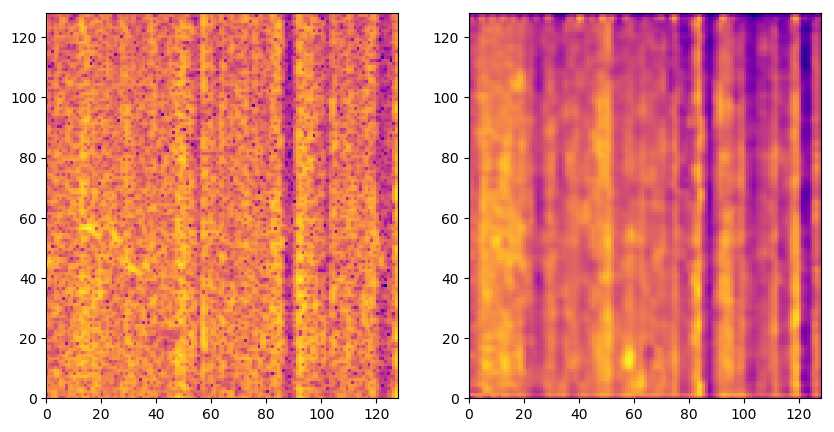

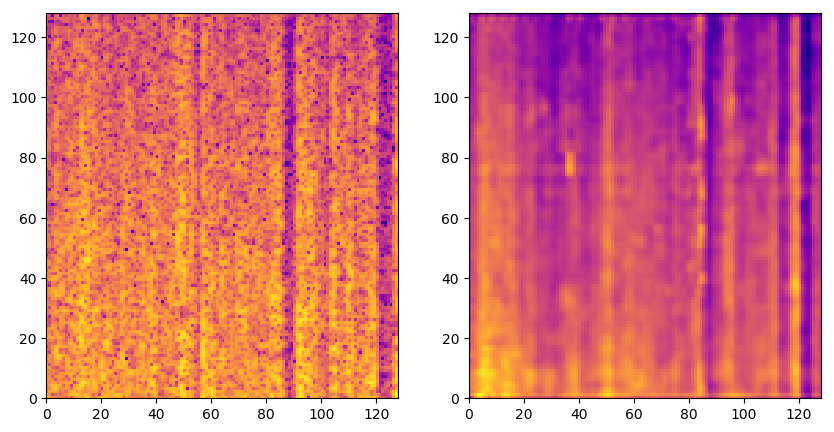

In [56]:
cmap="plasma"
for i in 1:size(testdata,4)
    figure(figsize=(10,5))
    subplot(1,2,1)
    pcolormesh(testdata[:,:,1,i], cmap=cmap)
    subplot(1,2,2)
    pcolormesh(model(testdata[:,:,:,i:i]).data[:,:,1,1], cmap=cmap)
    
end

In [27]:
testdata

128×128×1×20 Array{Float32,4}:
[:, :, 1, 1] =
 0.447427  0.516855  0.494727  0.460427  …  0.529323  0.577415  0.532051
 0.453219  0.454347  0.44418   0.420475     0.584043  0.558517  0.474909
 0.514975  0.48643   0.442757  0.396282     0.455009  0.433467  0.494107
 0.495185  0.432368  0.490147  0.448578     0.525699  0.485428  0.491679
 0.464101  0.419865  0.471839  0.53991      0.501981  0.492624  0.47323 
 0.334071  0.343542  0.384106  0.505619  …  0.56594   0.517853  0.508724
 0.473829  0.446025  0.456     0.471891     0.568246  0.460238  0.404199
 0.522004  0.520377  0.484454  0.463732     0.520916  0.441385  0.499877
 0.448988  0.468893  0.452846  0.41108      0.456236  0.493776  0.526785
 0.423493  0.439228  0.477778  0.348042     0.341702  0.471171  0.513445
 0.466588  0.528296  0.517114  0.439158  …  0.58658   0.574467  0.45946 
 0.483072  0.539747  0.519572  0.458855     0.650263  0.61959   0.525808
 0.491008  0.539173  0.371402  0.527332     0.579868  0.598682  0.554637
 ⋮   

In [19]:
GC.gc()

In [33]:
# now compute the code in batches
batchsize = 10
z = model.encoder(data[:,:,:,1:batchsize]).data;
for i in 2:floor(Int,size(data,4)/batchsize)
    z=cat(z, model.encoder(data[:,:,:,((i-1)*batchsize+1):i*batchsize]).data, dims=2)
end
z=cat(z, model.encoder(data[:,:,:,end-(size(data,4)%batchsize)+1:end]).data, dims=2);

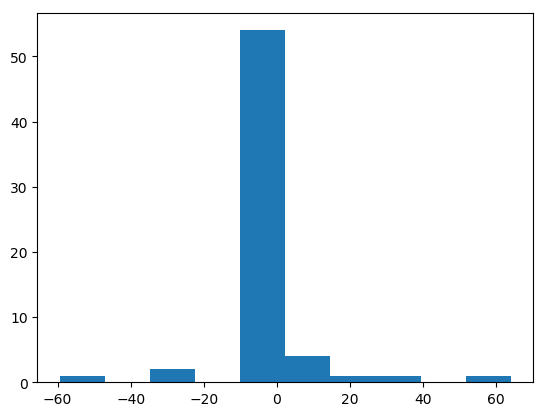

([1.0, 0.0, 2.0, 0.0, 54.0, 4.0, 1.0, 1.0, 0.0, 1.0], Float32[-59.3683, -47.022, -34.6757, -22.3294, -9.98308, 2.36323, 14.7095, 27.0559, 39.4022, 51.7485, 64.0948], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f7d41eb3358>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d39a37208>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d41eb3470>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d41eb3438>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d41eb30b8>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d417a82e8>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d417a8208>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d417a8f98>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d42199c50>, PyObject <matplotlib.patches.Rectangle object at 0x7f7d421991d0>])

In [34]:
plt.hist(mean(z,dims=2))

In [35]:
umap_model = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1)

PyObject UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [36]:
z2D = Array(umap_model.fit_transform(z')')

2×2024 Array{Float32,2}:
 10.6188    -6.40495  -7.6023   -8.01788  …  -6.92816  -7.13122  -7.43076
 -0.587378  -5.89184  -5.46045  -6.15161     -3.62257  -3.97413  -5.12352

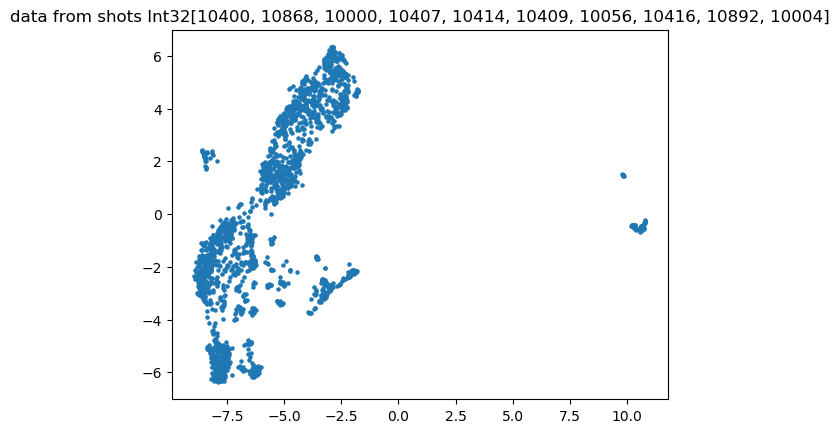

PyObject Text(0.5, 1.0, 'data from shots Int32[10400, 10868, 10000, 10407, 10414, 10409, 10056, 10416, 10892, 10004]')

In [37]:
scatter(z2D[1,:],z2D[2,:],s=5)
title("data from shots $(labeled_shots)")

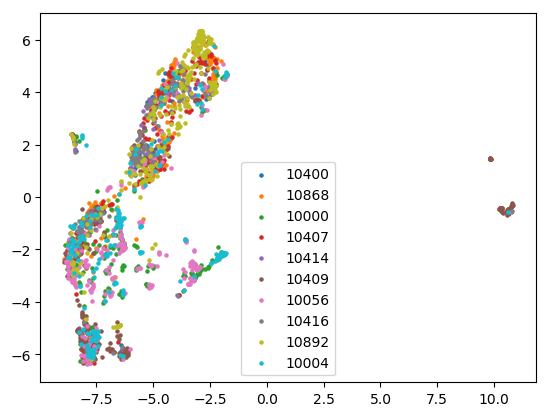

PyObject <matplotlib.legend.Legend object at 0x7f7d39cec518>

In [38]:
for shotno in unique(data_shotnos)
    zs = z2D[:,data_shotnos.==shotno]
    scatter(zs[1,:], zs[2,:],s=5,label="$shotno")
end
legend()

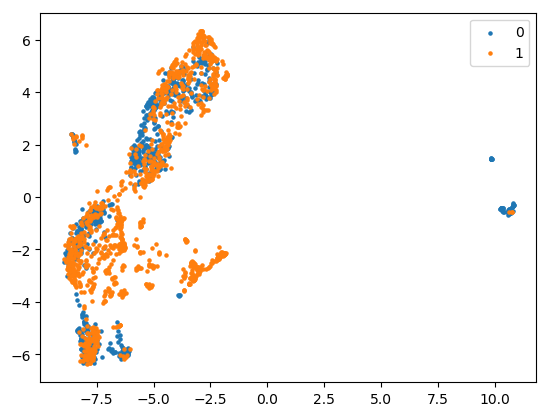

PyObject <matplotlib.legend.Legend object at 0x7f7d38e8e2b0>

In [39]:
for label in unique(data_labels)
    zs = z2D[:,data_labels.==label]
    scatter(zs[1,:], zs[2,:],s=5,label="$label")
end
legend()

In [40]:
testz = model.encoder(testdata).data;
testz2D = Array(umap_model.transform(testz')')

2×20 Array{Float32,2}:
 -4.01035  -3.70077  -3.36639  -3.76611  …  -2.7227   -3.49204  -3.38049
  5.25101   3.00215   5.94955   3.06776      3.92902   5.73611   3.91683

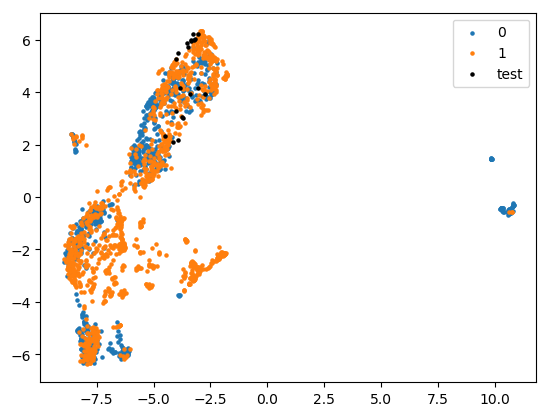

PyObject <matplotlib.legend.Legend object at 0x7f7d3a066198>

In [41]:
for label in unique(data_labels)
    zs = z2D[:,data_labels.==label]
    scatter(zs[1,:], zs[2,:],s=5,label="$label")
end
scatter(testz2D[1,:], testz2D[2,:],s=5,label="test",c="k")
legend()

In [ ]:
clusterinds = collect(1:size(z2D,2))[ (-50. .< z2D[1,:] .< -10) .&  (-10 .< z2D[2,:] .< 10)]
#clusterinds = collect(1:size(z2D,2))[ (-2. .< z2D[1,:] .< 1) .&  (0 .< z2D[2,:] .< 3)]
#clusterinds = collect(1:size(z2D,2))[ (0.5 .< z2D[1,:] .< 3) .&  (5.5 .< z2D[2,:] .< 6.5)]
scatter(z2D[1,clusterinds],z2D[2,clusterinds])
scatter(testz2D[1,:], testz2D[2,:],s=5,label="test",c="k")


In [ ]:
for i in clusterinds
    figure()
    pcolormesh(data[:,:,1,i], cmap="plasma")
    title("$i, label = $(data_labels[i])")
end

In [ ]:
plt.hist(mean(z,dims=2))

In [ ]:
plt.hist(mean(z[:,clusterinds],dims=2))